<a href="https://colab.research.google.com/github/Rizwankaka/Agentic-AI-/blob/main/Pydantic/pydanticai_research_assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Research Assistant using PydanticAI

The goal of this project is to build a research assistant (Research + Summarization) that helps users explore a research topic by iteratively:

1. **Generating search queries** based on the user’s input and performing web searches.
2. **Extracting and summarizing** relevant information from the search results.
3. **Organizing and updating** the collected information to maintain the state of the assistant.
4. **Delivering a comprehensive research report** to the user, complete with cited sources.

This project takes inspiration from the LangGraph tutorial . However, it simplifies the implementation by eliminating unnecessary dependencies and complexities. It also focuses on providing a more efficient and streamlined solution using the PydanticAI framework.

### Here's the architecture of the system
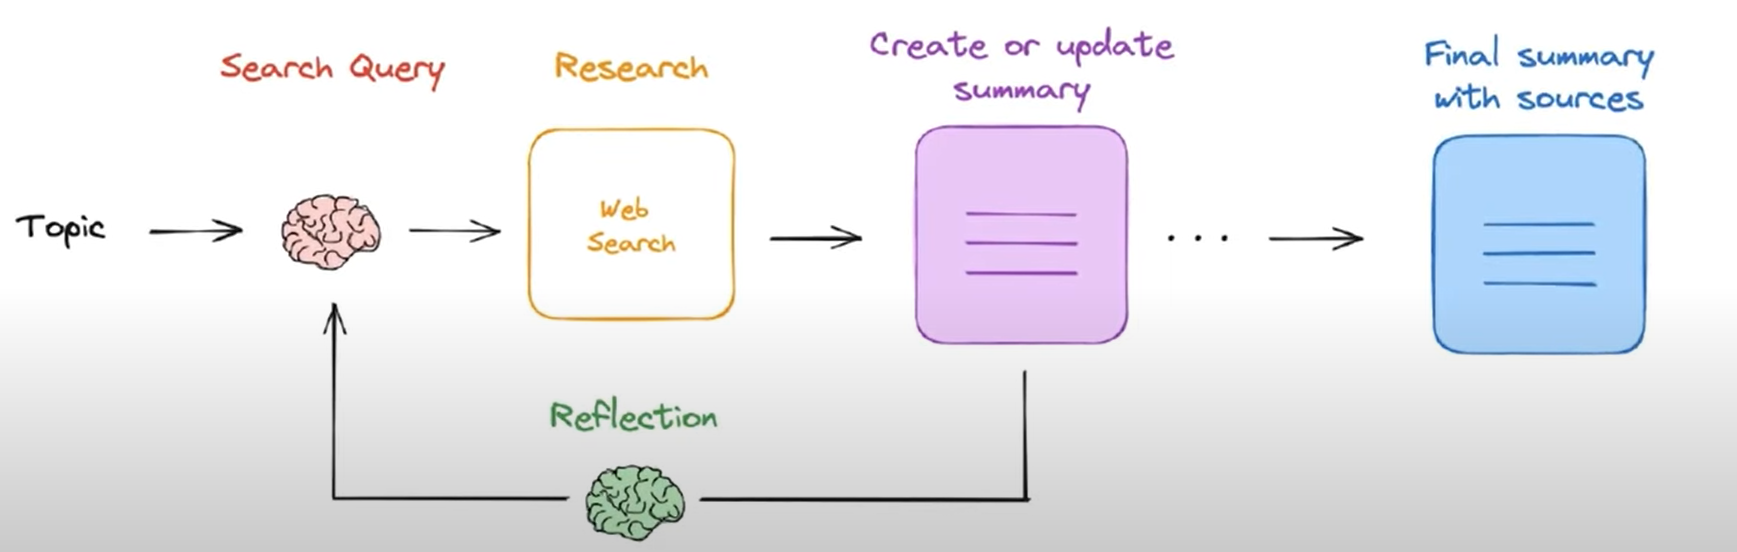

In [72]:
%pip install -qU pydantic-ai litellm nest-asyncio tavily-python google-auth==2.22.0 google-auth-oauthlib==1.0.0 google-cloud-aiplatform==1.36.0


In [73]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [77]:
from pydantic_ai import Agent, RunContext, Tool
from pydantic_ai.models.groq import GroqModel
from IPython.display import display, Markdown
from pydantic import BaseModel
from dataclasses import dataclass, field

from litellm import completion

import json
import litellm
import os
import nest_asyncio

# import logging
# logging.basicConfig(format="%(asctime)s %(message)s")
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)

# MAKE SURE to set the TAVILY_API_KEY environment variable
# export TAVILY_API_KEY=<your_tavily_api_key>

# Because we run the code in Jupyter lab, but not needed in production
nest_asyncio.apply()

from tavily import TavilyClient
tavily_client = TavilyClient()
litellm.set_verbose = False
MAX_WEB_SEARCH_LOOPS = 2

In [45]:
query_writer_system_prompt = """
Your goal is to generate a targeted web search query.

The query will gather information related to a specific topic.

Topic: {research_topic}

Return your query as a JSON object:
{{
    "query": "string",
    "aspect": "string",
    "rationale": "string"
}}
"""

summarizer_system_prompt = """
Your goal is to generate a high-quality summary of the web search results.

When EXTENDING an existing summary:
1. Seamlessly integrate new information without repeating what's already covered.
2. Maintain consistency with the existing content's style and depth.
3. Only add new, non-redundant information.
4. Ensure smooth transitions between existing and new content.

When creating a NEW summary:
1. Highlight the most relevant information from each source.
2. Provide a concise overview of the key points related to the report topic.
3. Emphasize significant findings or insights.
4. Ensure a coherent flow of information.

In both cases:
- Focus on factual, objective information.
- Maintain a consistent technical depth.
- Avoid redundancy and repetition.
- DO NOT use phrases like "based on the new results" or "according to additional sources."
- DO NOT add a preamble like "Here is an extended summary ..."
- DO NOT add a References or Works Cited section. Just directly output the summary.
"""

reflection_system_prompt = """
You are an expert research assistant analyzing a summary about {research_topic}.

Your tasks:
1. Identify knowledge gaps or areas that need deeper exploration.
2. Generate a follow-up question that would help expand your understanding.
3. Focus on technical details, implementation specifics, or emerging trends that weren't fully covered.

Ensure the follow-up question is self-contained and includes necessary context for web search.

Return your analysis as a JSON object:
{{
    "knowledge_gap": "string",
    "follow_up_query": "string"
}}
"""


In [46]:
def format_sources(sources):
    """
    Formats a list of source dictionaries into a structured text for LLM input.

    Args:
        sources (list): A list of dictionaries containing "title", "url", "content", and "score".

    Returns:
        str: Formatted text beginning with "Sources:\n\n" and each source's details on separate lines.
    """
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(sources, start=1):
        formatted_text += (
            f"Source {i}:\n"
            f"Title: {source['title']}\n"
            f"Url: {source['url']}\n"
            f"Content: {source['content']}\n\n"
        )
    return formatted_text.strip()


In [81]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class ResearchDeps:
    research_topic: str = None
    search_query: str = None
    current_summary: str = None
    final_summary: str = None
    sources: List[str] = field(default_factory=list)
    latest_web_search_result: str = None
    research_loop_count: int = 0

async def generate_search_query(ctx: RunContext[ResearchDeps]) -> str:
    """Generate a query for web search"""
    print("==== CALLING generate_search_query... ====")
    response = completion(
        model="llama-3.1-70b-versatile",
        messages=[{"content": query_writer_system_prompt.format(research_topic=ctx.deps.research_topic), "role": "system"}],
        max_tokens=500,
        response_format={"type": "json_object"},
        custom_llm_provider="groq"
    )
    search_query = json.loads(response.choices[0].message.content)
    ctx.deps.search_query = search_query["query"]
    return "perform_web_search"

async def perform_web_search(ctx: RunContext[ResearchDeps]) -> str:
    """Do search and collect information"""
    print("==== CALLING perform_web_search... ====")
    search_results = tavily_client.search(ctx.deps.search_query, include_raw_content=False, max_results=1)
    search_string = format_sources(search_results["results"])
    ctx.deps.sources.extend(search_results["results"])
    ctx.deps.latest_web_search_result = search_string
    ctx.deps.research_loop_count += 1
    return "summarize_sources"

async def summarize_sources(ctx: RunContext[ResearchDeps]) -> str:
    """Summarize the gathered sources"""
    print("==== CALLING summarize_sources... ====")
    current_summary = ctx.deps.current_summary
    most_recent_web_research = ctx.deps.latest_web_search_result
    if current_summary:
        user_prompt = (f"Extend the existing summary: {current_summary}\n\n"
                       f"Include new search results: {most_recent_web_research} "
                       f"That addresses the following topic: {ctx.deps.research_topic}")
    else:
        user_prompt = (
        f"Generate a summary of these search results: {most_recent_web_research} "
        f"That addresses the following topic: {ctx.deps.research_topic}"
    )

        response = completion(
          model="llama-3.1-70b-versatile",
          messages=[
              {"content": summarizer_system_prompt.format(research_topic=ctx.deps.research_topic), "role": "system"},
              {"content": user_prompt, "role": "user"}
          ],
          max_tokens=1000,
          custom_llm_provider="groq"
      )

        ctx.deps.current_summary = response.choices[0].message.content
        return "reflect_on_summary"

async def reflect_on_summary(ctx: RunContext[ResearchDeps]) -> str:
    """Reflect on the summary and generate a follow-up query"""
    print("==== CALLING reflect_on_summary... ====\n")
    response = completion(
        model="llama-3.1-70b-versatile",
        messages=[
            {"content": reflection_system_prompt.format(research_topic=ctx.deps.research_topic), "role": "system"},
            {"content": "Identify a knowledge gap and generate a follow-up web search query based on our existing knowledge:", "role": "user"}
        ],
        max_tokens=500,
        response_format={"type": "json_object"},
        custom_llm_provider="groq"

    )
    follow_up_query = json.loads(response.choices[0].message.content)
    ctx.deps.search_query = follow_up_query["follow_up_query"]
    return "continue_or_stop_research"

async def finalize_summary(ctx: RunContext[ResearchDeps]) -> str:
    """Finalize the summary"""
    print("==== CALLING finalize_summary... ====")
    all_sources = format_sources(ctx.deps.sources)
    ctx.deps.final_summary = f"## Summary:\n\n{ctx.deps.current_summary}\n\n{all_sources}"
    return f"STOP and return this summary: {ctx.deps.final_summary}"

async def continue_or_stop_research(ctx: RunContext[ResearchDeps]) -> str:
    """Decide to continue the research or stop based on the follow-up query"""
    print("==== CALLING continue_or_stop_research... ====")
    if ctx.deps.research_loop_count >= MAX_WEB_SEARCH_LOOPS:
        await finalize_summary(ctx)
        return "finalize_summary"
    else:
        return f"Iterations so far: {ctx.deps.research_loop_count}.\n\ngenerate_search_query"


In [82]:
from pydantic_ai.models.groq import GroqModel

model = GroqModel("llama-3.1-70b-versatile")

default_system_prompt = """
You are a researcher. You need to use your tools and provide a research.
You must STOP your research if you have done {max_loop} iterations.
"""

research_agent = Agent(
    model=model,
    system_prompt=default_system_prompt.format(max_loop=MAX_WEB_SEARCH_LOOPS),
    deps_type=ResearchDeps,
    tools=[
        Tool(generate_search_query),
        Tool(perform_web_search),
        Tool(summarize_sources),
        Tool(reflect_on_summary),
        Tool(finalize_summary),
        Tool(continue_or_stop_research)
    ]
)

topic = 'how to use SmolLM models?'

research_deps = ResearchDeps(research_topic=topic)
result = research_agent.run_sync(topic, deps=research_deps)

==== CALLING generate_search_query... ====

Provider List: https://docs.litellm.ai/docs/providers

==== CALLING perform_web_search... ====
==== CALLING summarize_sources... ====

Provider List: https://docs.litellm.ai/docs/providers

==== CALLING reflect_on_summary... ====


Provider List: https://docs.litellm.ai/docs/providers

==== CALLING continue_or_stop_research... ====
==== CALLING generate_search_query... ====

Provider List: https://docs.litellm.ai/docs/providers

==== CALLING perform_web_search... ====
==== CALLING summarize_sources... ====
==== CALLING reflect_on_summary... ====


Provider List: https://docs.litellm.ai/docs/providers

==== CALLING continue_or_stop_research... ====
==== CALLING finalize_summary... ====
==== CALLING finalize_summary... ====


In [83]:
from IPython.display import display, Markdown

Markdown(result.data)

The final answer to the user's question "How to use SmolLM models?" is:

The SmolLM models can be used for various applications such as text summarization, text rewriting, and function calling. The most powerful model, SmolLM2-1.7B-Instruct, can be used as an assistant with frameworks like transformers, trl, or quantized versions with tools like llama.cpp, MLX, and transformers.js. For lighter applications, the smaller models SmolLM2-360M and SmolLM2-135M are suitable for on-device usage and can be integrated similarly. To leverage the models, users can access the model card at https://huggingface.co/HuggingFaceTB/SmolLM2-1.7B-Instruct for more details on use cases and implementation. Additionally, the models can be used locally with frameworks like llama.cpp, MLX, and transformers.js, which support SmolLM2, and are part of a collection of lightweight AI-powered tools built with LLaMA.cpp and small language models.

Sources:

Source 1:
Title: smollm/README.md at main · huggingface/smollm · GitHub
Url: https://github.com/huggingface/smollm/blob/main/README.md

Source 2:
Title: How to Use SmolLM: Your Guide to State-of-the-Art Small Language Models ...
Url: https://fxis.ai/edu/how-to-use-smollm-your-guide-to-state-of-the-art-small-language-models/